In [6]:
from casatasks import tclean, split, listobs, uvcontsub
from pathlib import Path
from casatools import image as IA
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np
import io
import base64
from os import path, makedirs, remove, getcwd
import glob
from shutil import rmtree

In [3]:
# helpers

def __clear_tmp(wd,cimagename):
    filelist = glob.glob(path.join(wd, cimagename+'.*'))
    for f in filelist:
        try:
            rmtree(f)
        except OSError:
            remove(f)
def save_fig(plt, fig, kind='base64', output='output.jpg'):
    
    if kind == 'base64':
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight',
                    transparent=True, pad_inches=0)
        buf.seek(0)
        string = base64.b64encode(buf.read())
        plt.close()
        return string
    elif kind == 'plot':
        plt.show()
        return 'plotted'
    else :
        if not path.exists('output'):
            makedirs('output')
        newPath = 'output/'+output
        opt = newPath
        if path.exists(newPath):
            numb = 1
            while path.exists(newPath):
                newPath = "{0}_{2}{1}".format(
                    *path.splitext(opt) + (numb,))
                try :
                    if path.exists(newPath):
                        numb += 1 
                except:
                    pass               
        fig.savefig(newPath, format=kind, bbox_inches='tight',
                    pad_inches=0)
        print("saved {}".format(newPath))
        plt.close()
        return newPath


In [12]:
cwd = getcwd()
csource = str(Path.home()) + '/CASA/tests/test_d/sis14-working/sis14_twhya_selfcal.ms' # ms file as visibility input
csource_stem = str(Path(csource).stem) # filename for p1 creations

work_folder = str(Path.home()) + '/.casa/tmp/'+csource_stem+'/' # all creations inside this
if not path.exists(work_folder):
            makedirs(work_folder)
csource_smoothed = work_folder+csource_stem+'_p1.ms' # created by p1
cimagename=str(Path(csource_smoothed).stem) # created by p1 during tclean
rest_freq = '372.67249GHz'
science_imagename='twhya_n2hp'
science_vis = csource + '.contsub'
niter=5000

In [8]:
uvcontsub(vis = csource,
          field = '5',
          fitspw = '0:0~239;281~383',
          excludechans = False,
          fitorder = 0,
          solint='int')

2021-12-22 16:46:06	WARN	calibrater::setvi(bool,bool)	Already using OLD VisibilityIterator.


In [9]:
import os
os.system(f'rm -rf {science_imagename}.*')
tclean(vis = science_vis,
       imagename = science_imagename,
       field = '0',
       spw = '0',
       specmode = 'cube',
       perchanweightdensity=True,
       nchan = 15,
       start = '0.0km/s',
       width = '0.5km/s',
       outframe = 'LSRK',
       restfreq = rest_freq,
       deconvolver= 'hogbom',
       gridder = 'standard',
       imsize = [250, 250],
       cell = '0.08arcsec',
       phasecenter = 0,
       usemask='auto-multithresh',
       weighting = 'briggs',
       robust = 0.5,
       restoringbeam='common',
       interactive = False,
       niter=niter)

{}

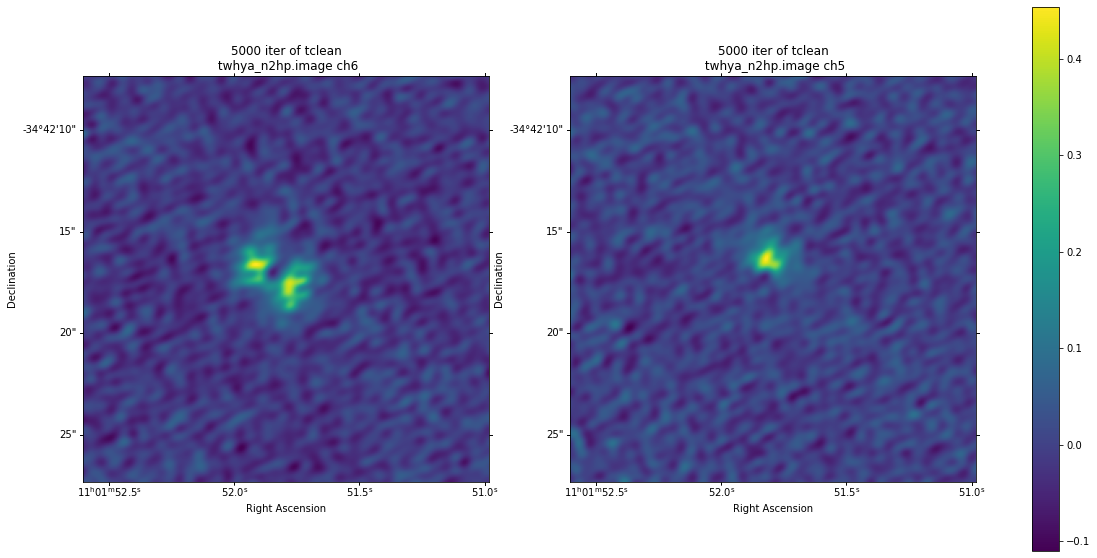

In [24]:
res_file = science_imagename + '.image'
model_file = science_imagename + '.image'

ia = IA()
ia.open(res_file)
pix = ia.getchunk()[:,:,0,6]
csys = ia.coordsys()
ia.close()

ia = IA()
ia.open(model_file)
pix_psf = ia.getchunk()[:,:,0,5]
csys = ia.coordsys()
ia.close()

rad_to_deg =  180/np.pi
w = WCS(naxis=2)
w.wcs.crpix = csys.referencepixel()['numeric'][0:2]
w.wcs.cdelt = csys.increment()['numeric'][0:2]*rad_to_deg
w.wcs.crval = csys.referencevalue()['numeric'][0:2]*rad_to_deg
w.wcs.ctype = ['RA---SIN', 'DEC--SIN']

fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1, projection=w)
p1 = int(pix.shape[0]*0.25)
p2 = int(pix.shape[0]*0.75)

im1 = ax1.imshow(pix.transpose(), origin='lower',  cmap=plt.cm.viridis)

ax1.set_xlabel('Right Ascension')
ax1.set_ylabel('Declination')
ax1.set_title(f'{niter} iter of tclean\n {res_file} ch6')
ax2 = plt.subplot(1, 2, 2, projection=w)
p1 = int(pix.shape[0]*0.25)
p2 = int(pix.shape[0]*0.75)
im2 = ax2.imshow(pix_psf.transpose(), origin='lower',  cmap=plt.cm.viridis)
#im2 = ax2.imshow(pix_psf[p1:p2,p1:p2].transpose(), origin='lower',  cmap=plt.cm.viridis)
fig.colorbar(im2, ax=[ax1,ax2])
ax2.set_xlabel('Right Ascension')
ax2.set_ylabel('Declination')
ax2.set_title(f'{niter} iter of tclean\n {model_file} ch5')

save_fig(plt, fig, kind='plot')

__clear_tmp(work_folder, '*')
__clear_tmp(cwd, cimagename)